# Hydrodynamic and Hydromagnetic eigenmodes of Plesio-Geostrophy Model

This notebook solves the eigenmodes of Plesio-Geostrophy (PG) model in a number of background fields. Plesio-Geostrophy model (see [Jackson and Maffei, 2020](https://doi.org/10.1098/rspa.2020.0513)) is a 2-D reduced model for 3-D MHD in rapidly rotating frame, based on near-geostrophic flows in an axisymmetric cavity.

Currently, only the axisymmetric background field is used.

In [1]:
%load_ext autoreload
%autoreload 2

# Symbolics
import sympy
from sympy import *
import pg_utils.sympy_supp.vector_calculus_3d as v3d

# PG Model
from pg_utils.pg_model import *
from pg_utils.pg_model import core
from pg_utils.pg_model import base_utils as pgutils

Conventions for fields

In [2]:
def display_eqs(lhs, rhs):
    display(*(sympy.Eq(lhs_tmp, rhs[idx]) for idx, lhs_tmp in enumerate(lhs)))

## Select equations

- Use linearized equations; 
- when calculating eigenvalue problems against a zero background velocity field, one can opt to use the linearized form of induction equation in cylindrical coordinates at the boundary, instead of the $B_r$ equation

In [3]:
from pg_utils.pg_model import equations as eqs

eqs_lin = eqs.eqs_pg_lin.copy()
activated = [True if idx != 14 else False for idx in range(eqs_lin.n_fields)]

### Choose forcing

The default is (almost) always to choose Lorentz force, since PG is mainly concerned with the expression with magnetic moments.

The following forces are possible but not yet implemented:
- viscous force / viscous diffusion: this can be readily expressed in terms of velocity field, which is known everywhere given the PG ansatz
- magnetic diffusion: according to Stefano, this is strictly NOT closed in PG variables. There might be ways to approximate them
- buoyancy force? It is mentioned in the 2020 paper, but not elaborated on. There is currently no temperature field in PG formulation
- boundary layer effects? I see Daria has the formulation of Ekman pumping in the latest notebook.

In [4]:
from pg_utils.pg_model import forcing
from pg_utils.pg_model import params

eqs_lin.Psi = sympy.Eq(eqs_lin.Psi.lhs, eqs_lin.Psi.rhs.subs({
    eqs.fe_p: params.Le**2*forcing.Le_p,
    eqs.fs_sym: params.Le**2*forcing.Ls_sym,
    eqs.fp_sym: params.Le**2*forcing.Lp_sym,
    eqs.fz_asym: params.Le**2*forcing.Lz_asym
}))
eqs_lin.Psi

Eq(s*Derivative(\psi(s, \phi, t), (s, 2), t)/H(s) - s*Derivative(H(s), s)*Derivative(\psi(s, \phi, t), s, t)/H(s)**2 + Derivative(\psi(s, \phi, t), s, t)/H(s) - Derivative(H(s), s)*Derivative(\psi(s, \phi, t), (\phi, 2), t)/(2*H(s)**2) + Derivative(\psi(s, \phi, t), (\phi, 2), t)/(s*H(s)), \mathrm{Le}**2*s*L_{e\phi}(s, \phi, t)*Derivative(H(s), s)/H(s) - \mathrm{Le}**2*\overline{L_\phi}(s, \phi, t)/(2*H(s)) - s*Derivative(\mathrm{Le}**2*\overline{L_\phi}(s, \phi, t), s)/(2*H(s)) + Derivative(\mathrm{Le}**2*\overline{L_s}(s, \phi, t), \phi)/(2*H(s)) + Derivative(\mathrm{Le}**2*\widetilde{L_z}(s, \phi, t), \phi)*Derivative(H(s), s)/(2*H(s)) - 2*Derivative(H(s), s)*Derivative(\psi(s, \phi, t), \phi)/H(s)**2)

## Background field

### Background velocity field

In [5]:
U0_val = v3d.Vector3D((S.Zero, S.Zero, S.Zero), core.cyl)
display_eqs(core.U0_vec, U0_val)

Eq(U_s^0(s, \phi, z), 0)

Eq(U_\phi^0(s, \phi, z), 0)

Eq(U_z^0(s, \phi, z), 0)

### Background magnetic field

Case 1. Malkus background field

In [6]:
B0_val = v3d.Vector3D((S.Zero, s, S.Zero), core.cyl)
display_eqs(core.B0_vec, B0_val)

Eq(B_s^0(s, \phi, z), 0)

Eq(B_\phi^0(s, \phi, z), s)

Eq(B_z^0(s, \phi, z), 0)

Case 2. toroidal quadrupolar field

In [ ]:
B0_val = v3d.Vector3D((S.Zero, s*(S.One - s**2 - z**2), S.Zero), core.cyl)
display_eqs(core.B0_vec, B0_val)

### Assemble the PG backgrounds

In [8]:
pgvar_bg_val = pgutils.assemble_background(B0=B0_val)
display_eqs(core.pgvar_bg, pgvar_bg_val)

Eq(\Psi^0(s, \phi), 0)

Eq(\overline{M_{ss}}^0(s, \phi), 0)

Eq(\overline{M_{\phi\phi}}^0(s, \phi), 2*s**2*sqrt(1 - s**2))

Eq(\overline{M_{s\phi}}^0(s, \phi), 0)

Eq(\widetilde{M_{sz}}^0(s, \phi), 0)

Eq(\widetilde{M_{\phi z}}^0(s, \phi), 0)

Eq(\widetilde{zM_{ss}}^0(s, \phi), 0)

Eq(\widetilde{zM_{\phi\phi}}^0(s, \phi), s**2*(1 - s**2))

Eq(\widetilde{zM_{s\phi}}^0(s, \phi), 0)

Eq(B_{es}^0(s, \phi), 0)

Eq(B_{e\phi}^0(s, \phi), s)

Eq(B_{ez}^0(s, \phi), 0)

Eq(B_{es, z}^0(s, \phi), 0)

Eq(B_{e\phi, z}^0(s, \phi), 0)

Eq(B_{r1}^0(\theta, \phi), 0)

Eq(B_s^{0+}(s, \phi), 0)

Eq(B_\phi^{0+}(s, \phi), s)

Eq(B_z^{0+}(s, \phi), 0)

Eq(B_s^{0-}(s, \phi), 0)

Eq(B_\phi^{0-}(s, \phi), s)

Eq(B_z^{0-}(s, \phi), 0)

### Visualization

#### magnetic field

In [9]:
import numpy as np
import matplotlib.pyplot as plt

B_fun = [sympy.lambdify((s, p, z), component, modules=["scipy", "numpy"]) for component in B0_val]

For 1-D axisymmetric case: radial profiles

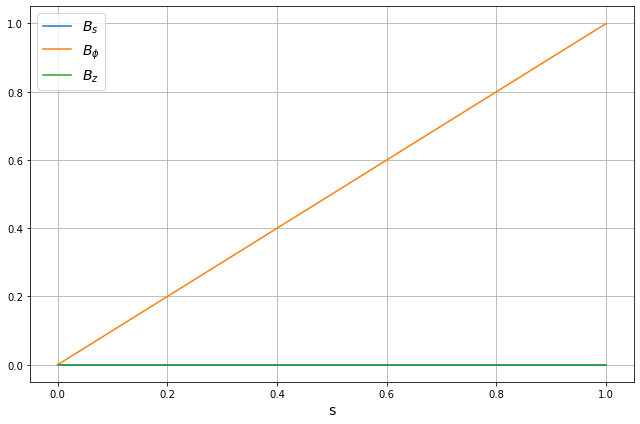

In [10]:
s_array = np.linspace(0, 1, num=100)

fig, ax = plt.subplots(figsize=(9, 6))
for i_comp, component in enumerate(B_fun):
    ax.plot(s_array, component(s_array, 0, 0)*np.ones(s_array.shape), label="$B_{:s}$".format(core.cyl.coords[i_comp].name))

ax.set_xlabel('s', fontsize=14)
ax.grid(True)
ax.legend(fontsize=14)
plt.tight_layout()
plt.show()

For non-axisymmetric case: equatorial and meridional cross-sections

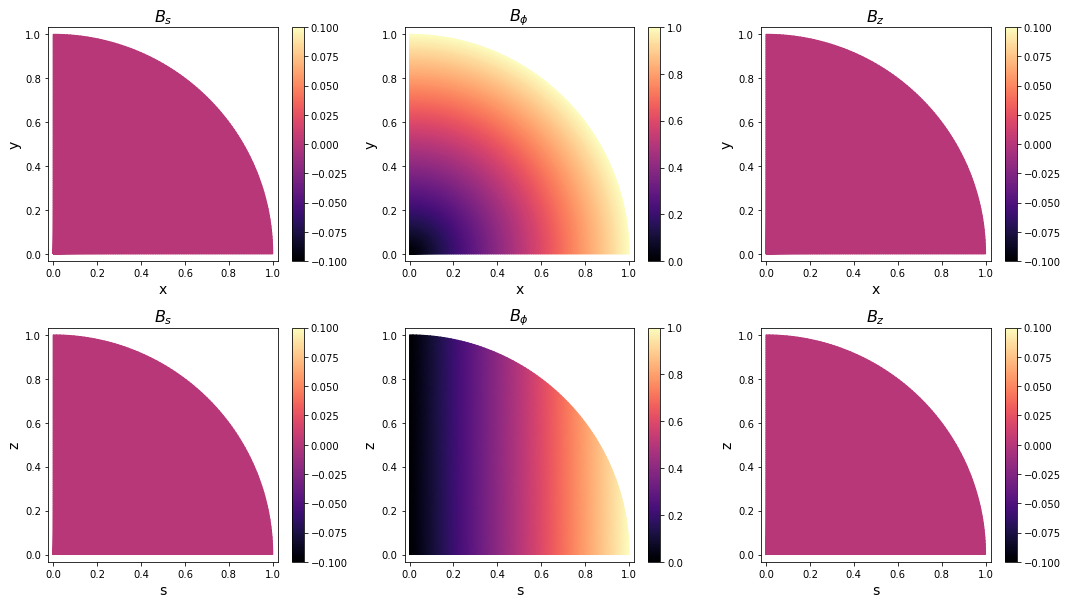

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8.5))

s_array = np.linspace(0, 1, num=100)
p_array = np.linspace(0, np.pi/2, num=100)
S_mesh, P_mesh = np.meshgrid(s_array, p_array)
X_mesh, Y_mesh = S_mesh*np.cos(P_mesh), S_mesh*np.sin(P_mesh)

for i_comp, component in enumerate(B_fun):
    ax = axes[0, i_comp]
    cm = ax.pcolormesh(X_mesh, Y_mesh, component(S_mesh, P_mesh, np.zeros(S_mesh.shape))*np.ones(S_mesh.shape), shading="gouraud", cmap="magma")
    ax.axis("equal")
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("y", fontsize=14)
    ax.set_title("$B_{:s}$".format(core.cyl.coords[i_comp].name), fontsize=16)
    plt.colorbar(cm, ax=ax)

p_cut = np.pi/2
r_array = np.linspace(0, 1, num=100)
t_array = np.linspace(0, np.pi/2, num=100)
R_mesh, T_mesh = np.meshgrid(r_array, t_array)
S_mesh, Z_mesh = R_mesh*np.sin(T_mesh), R_mesh*np.cos(T_mesh)

for i_comp, component in enumerate(B_fun):
    ax = axes[1, i_comp]
    cm = ax.pcolormesh(S_mesh, Z_mesh, component(S_mesh, p_cut*np.ones(S_mesh.shape), Z_mesh)*np.ones(S_mesh.shape), shading="gouraud", cmap="magma")
    ax.axis("equal")
    ax.set_xlabel("s", fontsize=14)
    ax.set_ylabel("z", fontsize=14)
    ax.set_title("$B_{:s}$".format(core.cyl.coords[i_comp].name), fontsize=16)
    plt.colorbar(cm, ax=ax)

plt.tight_layout()
plt.show()

#### magnetic moments

In [12]:
moments_fun = [sympy.lambdify((s, p, z), component, modules=["scipy", "numpy"]) for component in pgvar_bg_val.subset_moments()]

For axisymmetric fields: radial profile

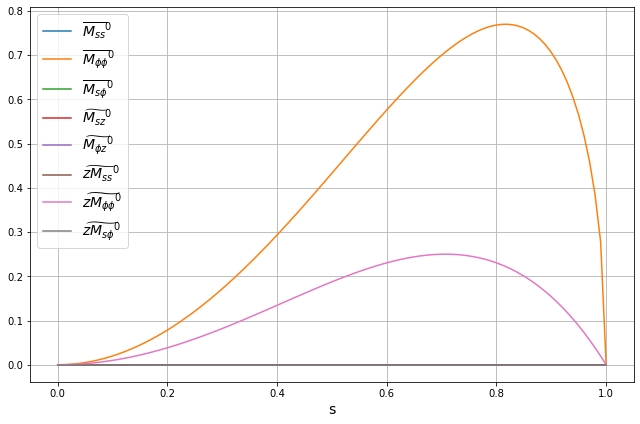

In [13]:
s_array = np.linspace(0, 1, num=100)

fig, ax = plt.subplots(figsize=(9, 6))
for i_comp, component in enumerate(moments_fun):
    ax.plot(s_array, component(s_array, 0, 0)*np.ones(s_array.shape), label="${:s}$".format(core.pgvar_bg.subset_moments()[i_comp].name))

ax.set_xlabel('s', fontsize=14)
ax.grid(True)
ax.legend(fontsize=14)
plt.tight_layout()
plt.show()

For non-axisymmetric case: equatorial cross-sections

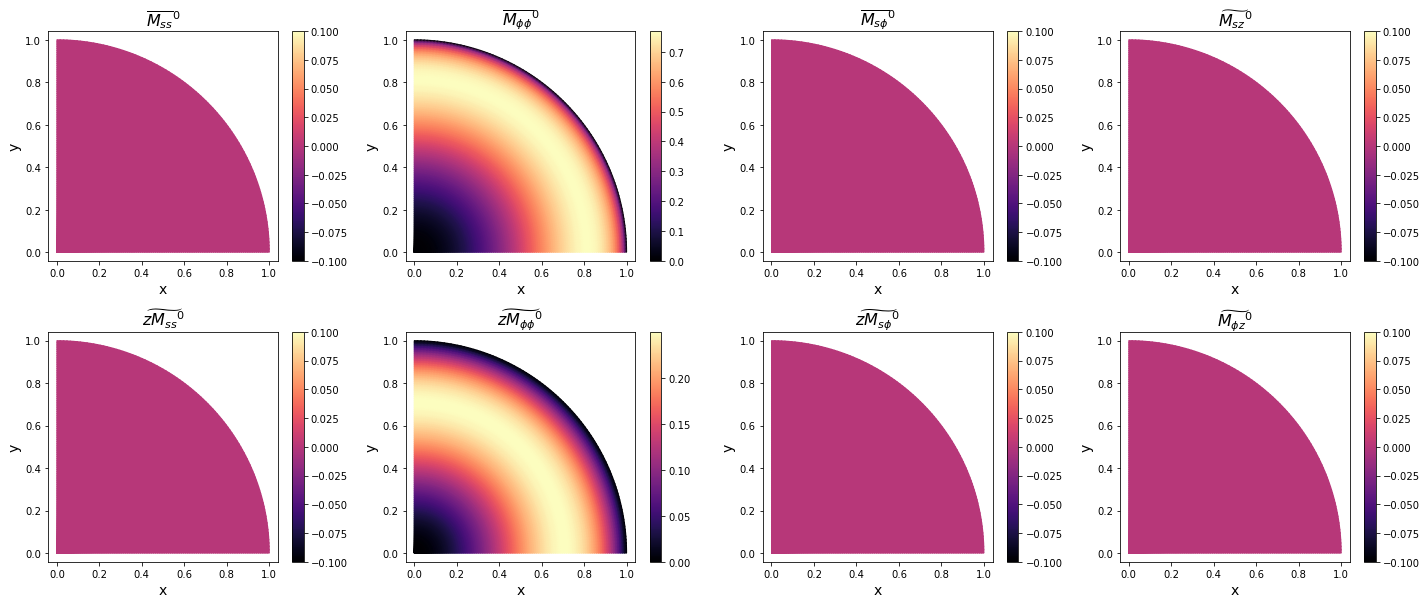

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8.5))

axis_arrangement = [(0, 0), (0, 1), (0, 2), (0, 3), (1, 3), (1, 0), (1, 1), (1, 2)]

s_array = np.linspace(0, 1, num=100)
p_array = np.linspace(0, np.pi/2, num=100)
S_mesh, P_mesh = np.meshgrid(s_array, p_array)
X_mesh, Y_mesh = S_mesh*np.cos(P_mesh), S_mesh*np.sin(P_mesh)

for i_comp, component in enumerate(moments_fun):
    ax = axes[axis_arrangement[i_comp][0], axis_arrangement[i_comp][1]]
    cm = ax.pcolormesh(X_mesh, Y_mesh, component(S_mesh, P_mesh, np.zeros(S_mesh.shape))*np.ones(S_mesh.shape), shading="gouraud", cmap="magma")
    ax.axis("equal")
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("y", fontsize=14)
    ax.set_title("${:s}$".format(core.pgvar_bg.subset_moments()[i_comp].name), fontsize=16)
    plt.colorbar(cm, ax=ax)

plt.tight_layout()
plt.show()

### Applying background field

In [9]:
# Explicit form of Lorentz force
Lorentz_explicit = {forcing.Le_p: forcing.Le_p_lin, forcing.Ls_sym: forcing.Ls_sym_lin, 
                    forcing.Lp_sym: forcing.Lp_sym_lin, forcing.Lz_asym: forcing.Lz_asym_lin}

# Substitution of background field
bg_field_sub = {u_comp: U0_val[i_comp] for i_comp, u_comp in enumerate(core.U0_vec)}
bg_field_sub.update({b_comp: B0_val[i_comp] for i_comp, b_comp in enumerate(core.B0_vec)})
bg_field_sub.update({pgvar_bg_comp: pgvar_bg_val[i_comp] for i_comp, pgvar_bg_comp in enumerate(core.pgvar_bg)})

def apply_bg(field_name, eq):
    if field_name == "Psi":
        new_lhs = eq.lhs.subs(bg_field_sub).subs({H: H_s}).doit().subs({H_s: H}).expand()
        new_rhs = eq.rhs.subs(Lorentz_explicit).subs(bg_field_sub).subs({H: H_s}).doit().subs({H_s: H}).expand()
    else:
        new_lhs = eq.lhs.subs(bg_field_sub).subs({H: H_s}).doit().simplify().expand().subs({H_s: H})
        new_rhs = eq.rhs.subs(bg_field_sub).subs({H: H_s}).doit().simplify().expand().subs({H_s: H})
    return sympy.Eq(new_lhs, new_rhs)

eqs_lin_bg = eqs_lin.apply(apply_bg, inplace=False, metadata=True)

# take limit at specific point for specific points
eqs_tmp = eqs_lin_bg.subset_B_equator()
for i_eq, eq in enumerate(eqs_tmp):
    eqs_tmp[i_eq] = sympy.Eq(eqs_tmp[i_eq].lhs, eqs_tmp[i_eq].rhs.subs({z: sympy.S.Zero}))

eqs_tmp = eqs_lin_bg.subset_B_bound_cyl()
for i_eq, eq in enumerate(eqs_tmp):
    if eqs_tmp._sub_names[i_eq][-1] == 'p':
        eqs_tmp[i_eq] = sympy.Eq(eqs_tmp[i_eq].lhs, eqs_tmp[i_eq].rhs.subs({z: +H}).doit().simplify().expand().subs({H_s: H, 1-s**2: H**2}))
    elif eqs_tmp._sub_names[i_eq][-1] == 'm':
        eqs_tmp[i_eq] = sympy.Eq(eqs_tmp[i_eq].lhs, eqs_tmp[i_eq].rhs.subs({z: -H}).doit().simplify().expand().subs({H_s: H, 1-s**2: H**2}))

display(*[eq for i_eq, eq in enumerate(eqs_lin_bg) if activated[i_eq]])

Eq(s**2*Derivative(\psi(s, \phi, t), s, t)/H(s)**3 + s*Derivative(\psi(s, \phi, t), (s, 2), t)/H(s) + s*Derivative(\psi(s, \phi, t), (\phi, 2), t)/(2*H(s)**3) + Derivative(\psi(s, \phi, t), s, t)/H(s) + Derivative(\psi(s, \phi, t), (\phi, 2), t)/(s*H(s)), -\mathrm{Le}**2*s**4*b_s^+(s, \phi, t)/(2*H(s)**4) - \mathrm{Le}**2*s**4*b_s^-(s, \phi, t)/(2*H(s)**4) - \mathrm{Le}**2*s**3*Derivative(b_s^+(s, \phi, t), s)/(2*H(s)**2) - \mathrm{Le}**2*s**3*Derivative(b_s^-(s, \phi, t), s)/(2*H(s)**2) - \mathrm{Le}**2*s**2*Derivative(b_z^+(s, \phi, t), s)/(2*H(s)) + \mathrm{Le}**2*s**2*Derivative(b_z^-(s, \phi, t), s)/(2*H(s)) - 3*\mathrm{Le}**2*s**2*b_s^+(s, \phi, t)/(2*H(s)**2) - 3*\mathrm{Le}**2*s**2*b_s^-(s, \phi, t)/(2*H(s)**2) - 2*\mathrm{Le}**2*s**2*b_{es}(s, \phi, t)/H(s)**2 - \mathrm{Le}**2*s**2*Derivative(b_{e\phi}(s, \phi, t), \phi)/H(s)**2 - \mathrm{Le}**2*s*b_z^+(s, \phi, t)/H(s) + \mathrm{Le}**2*s*b_z^-(s, \phi, t)/H(s) - \mathrm{Le}**2*s*Derivative(\overline{m_{s\phi}}(s, \phi, t), (s

Eq(Derivative(\overline{m_{ss}}(s, \phi, t), t), 0)

Eq(Derivative(\overline{m_{\phi\phi}}(s, \phi, t), t), -4*s*Derivative(\psi(s, \phi, t), \phi, s))

Eq(Derivative(\overline{m_{s\phi}}(s, \phi, t), t), 2*Derivative(\psi(s, \phi, t), (\phi, 2)))

Eq(Derivative(\widetilde{m_{sz}}(s, \phi, t), t), 0)

Eq(Derivative(\widetilde{m_{\phi z}}(s, \phi, t), t), -s*Derivative(\psi(s, \phi, t), (\phi, 2))/H(s))

Eq(Derivative(\widetilde{zm_{ss}}(s, \phi, t), t), 0)

Eq(Derivative(\widetilde{zm_{\phi\phi}}(s, \phi, t), t), -2*s*H(s)*Derivative(\psi(s, \phi, t), \phi, s))

Eq(Derivative(\widetilde{zm_{s\phi}}(s, \phi, t), t), H(s)*Derivative(\psi(s, \phi, t), (\phi, 2)))

Eq(Derivative(b_{es}(s, \phi, t), t), Derivative(\psi(s, \phi, t), (\phi, 2))/(s*H(s)))

Eq(Derivative(b_{e\phi}(s, \phi, t), t), -Derivative(\psi(s, \phi, t), \phi, s)/H(s))

Eq(Derivative(b_{ez}(s, \phi, t), t), 0)

Eq(Derivative(b_{es, z}(s, \phi, t), t), 0)

Eq(Derivative(b_{e\phi, z}(s, \phi, t), t), 0)

Eq(Derivative(b_s^+(s, \phi, t), t), Derivative(\psi(s, \phi, t), (\phi, 2))/(s*H(s)))

Eq(Derivative(b_\phi^+(s, \phi, t), t), -Derivative(\psi(s, \phi, t), \phi, s)/H(s))

Eq(Derivative(b_z^+(s, \phi, t), t), -Derivative(\psi(s, \phi, t), (\phi, 2))/H(s)**2)

Eq(Derivative(b_s^-(s, \phi, t), t), Derivative(\psi(s, \phi, t), (\phi, 2))/(s*H(s)))

Eq(Derivative(b_\phi^-(s, \phi, t), t), -Derivative(\psi(s, \phi, t), \phi, s)/H(s))

Eq(Derivative(b_z^-(s, \phi, t), t), Derivative(\psi(s, \phi, t), (\phi, 2))/H(s)**2)

For actually solving the set of equations, never include the boundary equations in cylindrical coordinates in the algebraic system. These
- cannot be time stepped anyway;
- should either be ignored (like Daria did in the notebook for Malkus case, and other cases where the boundary terms do vanish) or incorporated (because they are functions of $\psi$ solely)

The following code block extracts the first 14 equations of PG (the non-boundary equations), and store the boundary equations separately.

In [10]:
eqs_solve = base.LabeledCollection(eqs_lin_bg._field_names[:14], **{eqs_lin_bg._field_names[i_eq]: eqs_lin_bg[i_eq] for i_eq in range(14)})
eqs_boundary = base.LabeledCollection(eqs_lin_bg._field_names[-6:], **{eqs_lin_bg._field_names[i_eq]: eqs_lin_bg[i_eq] for i_eq in range(15, 21)})

### Reduced form

When the eigenvalue problem in PG formulation:
- does not involve magnetic diffusion
- has zero background velocity
then the system which originally involves 15+ variables can be reduced into a first-order system with only two variables (in the sense of dynamical variables).
The two relevant dynamical variables are the stream function $\psi$ and the Lorentz force term, which is denoted as $f_L$ below.
For details, please refer to the [formulation document](./formulations/PG_Assim.pdf).

Ideally, the reduction of original equations to this form should be done at the time when the forces are assembled.

When the forces have already been combined in the system, then extracting different terms can only be done case by case.
However, the routine below applies to any eigenvalue problem that only involves Lorentz force and Coriolis force.
Eigenvalue problems which involves viscous diffusion, convection term etc. might need extra work.

1. Extracting forces corresponding to Lorentz force

In [62]:
forcing_terms = eqs_lin_bg.Psi.rhs.args
f_psi = sympy.S.Zero
f_lorentz = sympy.S.Zero

for f_term in forcing_terms:
    if pgutils.fields_in_term(f_term, core.pgvar_ptb)[0] == core.pgvar_ptb.Psi:
        f_psi += f_term
    else:
        f_lorentz += f_term

2. The first equation (vorticity eq) now has right hand side of itself $\psi$ and Lorentz force
3. The second equation is the evolution equation for Lorentz force, as a function of $\psi$

In [76]:
f_lorentz_field = sympy.Function(r"f_L")(s, p, t)
eq_psi_reduced = sympy.Eq(eqs_lin_bg.Psi.lhs, f_psi + f_lorentz_field)

lorentz_subs = {eqs_lin_bg[i_f].lhs: eqs_lin_bg[i_f].rhs for i_f in range(1, eqs_lin_bg.n_fields) if activated[i_f]}
f_lorentz_var = diff(f_lorentz, t).doit().subs(lorentz_subs).doit()
f_lorentz_terms = [f_term.subs({H: H_s}).doit().subs({H_s: H}).expand() for f_term in f_lorentz_var.args]
f_lorentz_var = sympy.Add(*f_lorentz_terms)
eq_lorentz = sympy.Eq(diff(f_lorentz_field, t), f_lorentz_var)

display(eq_psi_reduced)
display(eq_lorentz)

Eq(s**2*Derivative(\psi(s, \phi, t), s, t)/H(s)**3 + s*Derivative(\psi(s, \phi, t), (s, 2), t)/H(s) + s*Derivative(\psi(s, \phi, t), (\phi, 2), t)/(2*H(s)**3) + Derivative(\psi(s, \phi, t), s, t)/H(s) + Derivative(\psi(s, \phi, t), (\phi, 2), t)/(s*H(s)), 2*s*Derivative(\psi(s, \phi, t), \phi)/H(s)**3 + f_L(s, \phi, t))

Eq(Derivative(f_L(s, \phi, t), t), \mathrm{Le}**2*s**2*Derivative(\psi(s, \phi, t), (\phi, 2), s)/H(s)**3 + \mathrm{Le}**2*s*Derivative(\psi(s, \phi, t), (\phi, 2), (s, 2))/H(s) - 2*\mathrm{Le}**2*s*Derivative(\psi(s, \phi, t), (\phi, 2))/H(s)**3 + \mathrm{Le}**2*s*Derivative(\psi(s, \phi, t), (\phi, 4))/(2*H(s)**3) + \mathrm{Le}**2*Derivative(\psi(s, \phi, t), (\phi, 2), s)/H(s) + \mathrm{Le}**2*Derivative(\psi(s, \phi, t), (\phi, 4))/(s*H(s)))

## Expanding the system

This section expands the PG fields into basis functions and reduces the system to linear systems.
This is the bridge between symbolic evaluation and numerical computations.

In the first part we shall only work with full system (14 equations)

### Recipe setup

The standard way to set up the expansion recipe is now to use a configuration file.
For an example, see `cfg_expand`.

In [15]:
from pg_utils.pg_model import expansion as xpd
from pg_utils.pg_model import cfg_expand as cfg
from pg_utils.pg_model.expansion import omega, n, m, xi

In [16]:
expand_recipe = xpd.ExpansionRecipe(
    equations=eqs_solve, 
    fourier_expand=cfg.fourier_expand,
    rad_expand=cfg.rad_expand,
    rad_test=cfg.test_s,
    inner_prod_op=cfg.inner_prod_op
)

### Reduce to linear system

In [17]:
fourier_map = base.map_collection(cfg.fourier_expand.fields, cfg.fourier_expand)
eqs_s = expand_recipe.equations.apply(
    lambda eq: sympy.Eq(xpd.FourierExpansions.to_fourier_domain(eq.lhs, fourier_map, cfg.fourier_expand.bases), 
                        xpd.FourierExpansions.to_fourier_domain(eq.rhs, fourier_map, cfg.fourier_expand.bases)),
    inplace=False, metadata=False)

rad_map = base.map_collection(cfg.rad_expand.fields, cfg.rad_expand)
eig_t = sympy.I*xpd.omega
def inner_product_form(f_name, eq):
    old_lhs, old_rhs = (eq.lhs.subs(rad_map)/eig_t).doit().expand(), eq.rhs.subs(rad_map).doit().expand()
    new_lhs, new_rhs = sympy.S.Zero, sympy.S.Zero
    for coeff in cfg.rad_expand.coeffs:
        if not old_lhs.coeff(coeff, 1).equals(sympy.S.Zero):
            new_lhs += eig_t*coeff*cfg.inner_prod_op[f_name](cfg.test_s[f_name], old_lhs.coeff(coeff, 1))
        if not old_rhs.coeff(coeff, 1).equals(sympy.S.Zero):
            new_rhs += coeff*cfg.inner_prod_op[f_name](cfg.test_s[f_name], old_rhs.coeff(coeff, 1))
    return sympy.Eq(new_lhs, new_rhs)
eqs_s.apply(inner_product_form, inplace=True, metadata=True)

In [18]:
display(*[eq for i_eq, eq in enumerate(eqs_s) if activated[i_eq]])

Eq(I*\omega*C_{\Psi}^{mn}(s)*InnerProduct1D(\Phi_{\Psi}^{mn}(s), -m**2*s*\Phi_{\Psi}^{mn}(s)/(2*H(s)**3) - m**2*\Phi_{\Psi}^{mn}(s)/(s*H(s)) + s**2*Derivative(\Phi_{\Psi}^{mn}(s), s)/H(s)**3 + s*Derivative(\Phi_{\Psi}^{mn}(s), (s, 2))/H(s) + Derivative(\Phi_{\Psi}^{mn}(s), s)/H(s), 1, s, 0, 1), C_{\Psi}^{mn}(s)*InnerProduct1D(\Phi_{\Psi}^{mn}(s), 2*I*m*s*\Phi_{\Psi}^{mn}(s)/H(s)**3, 1, s, 0, 1) + C_{\phi z}^{mn}(s)*InnerProduct1D(\Phi_{\Psi}^{mn}(s), \mathrm{Le}**2*m**2*\Phi_{\phi z}^{mn}(s)/(2*H(s)**2), 1, s, 0, 1) + C_{\phi\phi}^{mn}(s)*InnerProduct1D(\Phi_{\Psi}^{mn}(s), -I*\mathrm{Le}**2*m*Derivative(\Phi_{\phi\phi}^{mn}(s), s)/(2*H(s)) - I*\mathrm{Le}**2*m*\Phi_{\phi\phi}^{mn}(s)/(2*s*H(s)), 1, s, 0, 1) + C_{e\phi}^{mn}(s)*InnerProduct1D(\Phi_{\Psi}^{mn}(s), -I*\mathrm{Le}**2*m*s**2*\Phi_{e\phi}^{mn}(s)/H(s)**2, 1, s, 0, 1) + C_{es}^{mn}(s)*InnerProduct1D(\Phi_{\Psi}^{mn}(s), -I*\mathrm{Le}**2*m*s**2*\Phi_{es}^{mn}(s)/H(s)**2 - 2*\mathrm{Le}**2*s**2*\Phi_{es}^{mn}(s)/H(s)**2, 1, s

Eq(I*\omega*C_{ss}^{mn}(s)*InnerProduct1D(\Phi_{ss}^{mn}(s), \Phi_{ss}^{mn}(s), 1, s, 0, 1), 0)

Eq(I*\omega*C_{\phi\phi}^{mn}(s)*InnerProduct1D(\Phi_{\phi\phi}^{mn}(s), \Phi_{\phi\phi}^{mn}(s), 1, s, 0, 1), C_{\Psi}^{mn}(s)*InnerProduct1D(\Phi_{\phi\phi}^{mn}(s), -4*I*m*s*Derivative(\Phi_{\Psi}^{mn}(s), s), 1, s, 0, 1))

Eq(I*\omega*C_{s\phi}^{mn}(s)*InnerProduct1D(\Phi_{s\phi}^{mn}(s), \Phi_{s\phi}^{mn}(s), 1, s, 0, 1), C_{\Psi}^{mn}(s)*InnerProduct1D(\Phi_{s\phi}^{mn}(s), -2*m**2*\Phi_{\Psi}^{mn}(s), 1, s, 0, 1))

Eq(I*\omega*C_{sz}^{mn}(s)*InnerProduct1D(\Phi_{sz}^{mn}(s), \Phi_{sz}^{mn}(s), 1, s, 0, 1), 0)

Eq(I*\omega*C_{\phi z}^{mn}(s)*InnerProduct1D(\Phi_{\phi z}^{mn}(s), \Phi_{\phi z}^{mn}(s), 1, s, 0, 1), C_{\Psi}^{mn}(s)*InnerProduct1D(\Phi_{\phi z}^{mn}(s), m**2*s*\Phi_{\Psi}^{mn}(s)/H(s), 1, s, 0, 1))

Eq(I*\omega*C_{zss}^{mn}(s)*InnerProduct1D(\Phi_{zss}^{mn}(s), \Phi_{zss}^{mn}(s), 1, s, 0, 1), 0)

Eq(I*\omega*C_{z\phi\phi}^{mn}(s)*InnerProduct1D(\Phi_{z\phi\phi}^{mn}(s), \Phi_{z\phi\phi}^{mn}(s), 1, s, 0, 1), C_{\Psi}^{mn}(s)*InnerProduct1D(\Phi_{z\phi\phi}^{mn}(s), -2*I*m*s*H(s)*Derivative(\Phi_{\Psi}^{mn}(s), s), 1, s, 0, 1))

Eq(I*\omega*C_{zs\phi}^{mn}(s)*InnerProduct1D(\Phi_{zs\phi}^{mn}(s), \Phi_{zs\phi}^{mn}(s), 1, s, 0, 1), C_{\Psi}^{mn}(s)*InnerProduct1D(\Phi_{zs\phi}^{mn}(s), -m**2*H(s)*\Phi_{\Psi}^{mn}(s), 1, s, 0, 1))

Eq(I*\omega*C_{es}^{mn}(s)*InnerProduct1D(\Phi_{es}^{mn}(s), \Phi_{es}^{mn}(s), 1, s, 0, 1), C_{\Psi}^{mn}(s)*InnerProduct1D(\Phi_{es}^{mn}(s), -m**2*\Phi_{\Psi}^{mn}(s)/(s*H(s)), 1, s, 0, 1))

Eq(I*\omega*C_{e\phi}^{mn}(s)*InnerProduct1D(\Phi_{e\phi}^{mn}(s), \Phi_{e\phi}^{mn}(s), 1, s, 0, 1) + I*\omega*C_{es}^{mn}(s)*InnerProduct1D(\Phi_{e\phi}^{mn}(s), \Phi_{es}^{mn}(s), 1, s, 0, 1), C_{\Psi}^{mn}(s)*InnerProduct1D(\Phi_{e\phi}^{mn}(s), -I*m*Derivative(\Phi_{\Psi}^{mn}(s), s)/H(s), 1, s, 0, 1))

Eq(I*\omega*C_{ez}^{mn}(s)*InnerProduct1D(\Phi_{ez}^{mn}(s), \Phi_{ez}^{mn}(s), 1, s, 0, 1), 0)

Eq(I*\omega*C_{es,z}^{mn}(s)*InnerProduct1D(\Phi_{es,z}^{mn}(s), \Phi_{es,z}^{mn}(s), 1, s, 0, 1), 0)

Eq(I*\omega*C_{e\phi,z}^{mn}(s)*InnerProduct1D(\Phi_{e\phi,z}^{mn}(s), \Phi_{e\phi,z}^{mn}(s), 1, s, 0, 1), 0)

### What are the matrix elements?

In [19]:
exprs_mass = base.LabeledCollection(eqs_s._field_names, 
    **{fname: eqs_s[fname].lhs/eig_t for fname in eqs_s._field_names})
exprs_stiff = base.LabeledCollection(eqs_s._field_names, 
    **{fname: eqs_s[fname].rhs for fname in eqs_s._field_names})
M_expr = xpd.SystemMatrix(exprs_mass, cfg.coeff_s)
K_expr = xpd.SystemMatrix(exprs_stiff, cfg.coeff_s)

bases_map = base.map_collection(cfg.bases_s, cfg.bases_s_expression)
n_test = sympy.Symbol("\ell")
n_trial = sympy.Symbol("\ell'")

In [20]:
ele_tmp = M_expr["Msp", "Msp"]
display(ele_tmp)

if isinstance(ele_tmp, xpd.InnerProduct1D):
    ele_tmp = ele_tmp.subs(bases_map).subs({H_s: H, H_s**2: H**2}).expand().subs({H: H_s})
    ele_tmp._opd_A = ele_tmp._opd_A.subs({n: n_test})
    ele_tmp._opd_B = ele_tmp._opd_B.subs({n: n_trial})
    display(ele_tmp)
    display(ele_tmp.integral_form())

    ele_tmp = ele_tmp.change_variable(xi, xpd.s_xi, xpd.xi_s, assuming_positive=True)
    display(ele_tmp.integral_form())

InnerProduct1D(\Phi_{s\phi}^{mn}(s), \Phi_{s\phi}^{mn}(s), 1, s, 0, 1)

InnerProduct1D(s**Abs(Abs(m) - 2)*(1 - s**2)*jacobi(n, 2, Abs(Abs(m) - 2) - 1/2, 2*s**2 - 1), s**Abs(Abs(m) - 2)*(1 - s**2)*jacobi(n, 2, Abs(Abs(m) - 2) - 1/2, 2*s**2 - 1), 1, s, 0, 1)

Integral(s**(2*Abs(Abs(m) - 2))*(1 - s**2)**2*jacobi(\ell, 2, Abs(Abs(m) - 2) - 1/2, 2*s**2 - 1)*jacobi(\ell', 2, Abs(Abs(m) - 2) - 1/2, 2*s**2 - 1), (s, 0, 1))

Integral((1/2 - \xi/2)**2*(\xi/2 + 1/2)**Abs(Abs(m) - 2)*jacobi(\ell, 2, Abs(Abs(m) - 2) - 1/2, \xi)*jacobi(\ell', 2, Abs(Abs(m) - 2) - 1/2, \xi)/(4*sqrt(\xi/2 + 1/2)), (\xi, -1, 1))

In [164]:
import numpy as np

p1 = sympy.Symbol("p_1", positive=True)
p2 = sympy.Symbol("p_2", positive=True)

m_val = 10

def get_min_power(expr, *args):
    if isinstance(term_opB, sympy.Add):
        min_tmp = np.array([get_min_power(arg) for arg in expr.args])
        return min_tmp.min(axis=0)
    else:
        expr = expr.factor()
        min_powers = np.array([2*Abs(m_val) for symb in args])
        for arg in expr.args:
            if isinstance(arg, sympy.Pow):
                base, exp = arg.as_base_exp()
            else:
                base, exp = arg, sympy.S.One
            for i_symb, symb in enumerate(args):
                if base == symb and exp < min_powers[i_symb]:
                    min_powers[i_symb] = exp
        min_powers[min_powers == 2*Abs(m_val)] = sympy.S.Zero
        return min_powers

term_opA = ele_tmp._opd_A.subs({m: m_val}).doit()
display(term_opA)
print(get_min_power(term_opA, 1 + xi, 1 - xi, xi - 1))

term_opB = (ele_tmp._wt*ele_tmp._opd_B).subs({m: m_val}).doit().xreplace({1+xi: p1, 1-xi: p2, xi-1: -p2})
display(term_opB)
print(get_min_power(term_opB, p1, p1, -p2))

ele_tmp.integral_form().subs({m: m_val})

(1/2 - \xi/2)*(\xi/2 + 1/2)**4*jacobi(\ell, 2, 15/2, \xi)

[4 0 1]


(1/2 - \xi/2)*(\xi/2 + 1/2)**(7/2)*jacobi(\ell', 2, 15/2, \xi)/4

[0 0 0]


Integral((1/2 - \xi/2)**2*(\xi/2 + 1/2)**(15/2)*jacobi(\ell, 2, 15/2, \xi)*jacobi(\ell', 2, 15/2, \xi)/4, (\xi, -1, 1))

## Assembling matrices

For axisymmetric background fields, different azimuthal wavenumbers $m$ are decoupled.

The following section assembles the mass and stiffness matrices for a specific azimuthal wavenumber.

In [49]:
from sympy.integrals import quadrature as quad
import numpy as np

m_val = 3
azm_val = {m: m_val}
par_val = {params.Le: 1e-4, params.Lu: 1e-3}

Nmax = sympy.Integer(5)
Nmoment = 2*Nmax
quad_N = Nmoment + 1
prec = 32

#### Mass matrix

In [50]:
ip_tmp = M_expr["Psi", "Psi"].subs(bases_map)
alpha = sympy.Rational(3, 2)
beta = m_val
xi_quad, wt_quad = quad.gauss_jacobi(quad_N, alpha, beta, prec)

ip_tmp = ip_tmp.subs({m: m_val}).subs({H_s: H, H_s**2: H**2}).expand().subs({H: H_s}).change_variable(xi, xpd.s_xi, xpd.xi_s)
opd_A = ip_tmp._opd_A.subs({n: n_test})
opd_B = ip_tmp._opd_B.subs({n: n_trial})
integrand = opd_A*ip_tmp._wt*opd_B/(1 - xi)**alpha/(1 + xi)**beta
# display(integrand)

def int_jacobi(integrand, Nmax):
    M_psi = list()
    for n_test_val in range(Nmax + 1):
        M_row = list()
        for n_trial_val in range(Nmax + 1):
            integrand_eval = integrand.subs({n_test: n_test_val, n_trial: n_trial_val}).doit()
            quad_pts = [wt_quad[i]*integrand_eval.subs({xi: xi_quad[i]}, n=prec) for i in range(quad_N)]
            quad_result = sum(quad_pts)
            M_row.append(sympy.nsimplify(quad_result, rational=True, tolerance=1e-20))
        M_psi.append(M_row)
    return sympy.Matrix(M_psi)

In [64]:
integrand_func = sympy.lambdify([n_test, n_trial, xi], integrand.doit(), modules=["scipy", "numpy"])

In [73]:
# print(integrand_func.__doc__)
integrand_func(np.array([[0, 1], [0, 1]]), np.array([[0, 1], [1, 0]]), np.array([[0., 0.], [0., 0.]]))

Created with lambdify. Signature:

func(\ell, \ell', \xi)

Expression:

(1/2 - \xi/2)**(3/2)*(\xi/2 + 1/2)*(-9*(1/2 - \xi/2)*(\xi/2 +...

Source code:

def _lambdifygenerated(Dummy_7884, Dummy_7883, Dummy_7882):
    return (1/4)*(1/2 - 1/2*Dummy_7882)**(3/2)*((1/2)*Dummy_7882 + 1/2)*(-9*(1/2 - 1/2*Dummy_7882)*((1/2)*Dummy_7882 + 1/2)*eval_jacobi(Dummy_7883, 3/2, 3, Dummy_7882) - 9/2*((1/2)*Dummy_7882 + 1/2)**2*eval_jacobi(Dummy_7883, 3/2, 3, Dummy_7882) + ((1/2)*Dummy_7882 + 1/2)*((1/2 - 1/2*Dummy_7882)**(3/2)*((1/2)*Dummy_7882 + 1/2)*(2*Dummy_7883 + 11)*(((1/2)*Dummy_7882 + 1/2)*(2*Dummy_7883 + 13)*eval_jacobi(Dummy_7883 - 2, 7/2, 5, Dummy_7882) + eval_jacobi(Dummy_7883 - 1, 5/2, 4, Dummy_7882)) + 6*(1/2 - 1/2*Dummy_7882)**(3/2)*((1/2)*Dummy_7882 + 1/2)*(2*Dummy_7883 + 11)*eval_jacobi(Dummy_7883 - 1, 5/2, 4, Dummy_7882) + 6*(1/2 - 1/2*Dummy_7882)**(3/2)*eval_jacobi(Dummy_7883, 3/2, 3, Dummy_7882) - 6*sqrt(1/2 - 1/2*Dummy_7882)*((1/2)*Dummy_7882 + 1/2)**2*(2*Dummy_7883 + 11)*eval_jacob

array([[-0.28173786, -0.32006249],
       [ 0.42674999,  0.21130339]])

In [72]:
integrand.subs({n_test: 1, n_trial: 1, xi: 0}).doit().evalf(32)

-0.32006249324215310308573375179258

In [91]:
def int_jacobi_numpy(integrand, Nmax):
    integrand_func = sympy.lambdify([n_test, n_trial, xi], integrand.doit(), modules=["scipy", "numpy"])
    Ntest, Ntrial, Xi = np.meshgrid(np.arange(int(Nmax) + 1), np.arange(int(Nmax) + 1), np.array(xi_quad, dtype=np.float64), indexing='ij')
    return np.sum(integrand_func(Ntest, Ntrial, Xi)*np.array(wt_quad, dtype=np.float64), axis=-1)

In [75]:
%%prun -s "cumulative" -T out/quadrature_profile.txt -q

M_psi = int_jacobi(integrand, Nmax)
M_psi

 
*** Profile printout saved to text file 'out/quadrature_profile.txt'.


In [76]:
M_psi

Matrix([
[-136/385,          0,        0,          0,           0,             0],
[       0, -3296/3465,        0,          0,           0,             0],
[       0,          0, -240/143,          0,           0,             0],
[       0,          0,        0, -8160/3289,           0,             0],
[       0,          0,        0,          0, -19880/5967,             0],
[       0,          0,        0,          0,           0, -211008/50065]])

In [77]:
M_psi.evalf(10)

Matrix([
[-0.3532467532,             0,            0,            0,            0,            0],
[            0, -0.9512265512,            0,            0,            0,            0],
[            0,             0, -1.678321678,            0,            0,            0],
[            0,             0,            0, -2.480997264,            0,            0],
[            0,             0,            0,            0, -3.331657449,            0],
[            0,             0,            0,            0,            0, -4.214680915]])

In [92]:
%%prun -s "cumulative" -T out/quadrature_profile_lambdify.txt -q

M_psi = int_jacobi_numpy(integrand, Nmax)

 
*** Profile printout saved to text file 'out/quadrature_profile_lambdify.txt'.


In [99]:
sympy.nsimplify(M_psi, rational=True, tolerance=1e-9)

[[-136/385, 0, 0, 0, 0, 0], [0, -3296/3465, 0, 0, 0, 0], [0, 0, -240/143, 0, 0, 0], [0, 0, 0, -8160/3289, 0, 0], [0, 0, 0, 0, -19880/5967, 0], [0, 0, 0, 0, 0, -211008/50065]]

In [51]:
ip_tmp = eqs_s.Psi.lhs.coeff(cfg.rad_expand.coeffs.Psi)
integrand = ip_tmp._opd_A*ip_tmp._opd_B/sympy.I/omega
integrand = integrand.subs(base.map_collection(cfg.bases_s, cfg.bases_s_expression))
integrand = integrand.subs({H_s: H, 1-s**2: H**2}).expand().subs({H: H_s})
integrand

-m**2*s*s**(2*Abs(m))*(1 - s**2)**(3/2)*jacobi(n, 3/2, Abs(m), 2*s**2 - 1)**2/2 - m**2*s**(2*Abs(m))*(1 - s**2)**(5/2)*jacobi(n, 3/2, Abs(m), 2*s**2 - 1)**2/s

In [61]:
ip_tmp = eqs_s.Psi.lhs.coeff(cfg.rad_expand.coeffs.Psi, 1)
alpha = sympy.Rational(3, 2)
beta = m_val
xi_quad, wt_quad = quad.gauss_jacobi(quad_N, alpha, beta, 32)

n_test_array = np.arange(Nmax + 1)
n_trial_array = np.arange(Nmax + 1)
M_psi = list()
bases_map = base.map_collection(cfg.bases_s, cfg.bases_s_expression)

for n_test in n_test_array:
    M_row = list()
    for n_trial in n_trial_array:
        integrand = (ip_tmp._opd_B/sympy.I/omega).subs({H_s: H, H_s**2: H**2}).expand().subs({H: H_s}).subs(bases_map).subs({n: n_trial, m: m_val})
        integrand = ip_tmp._opd_A.subs(bases_map).subs({n: n_test, m: m_val})*integrand
        integrand = integrand.subs({s: expansion.s_xi})/(1 - xi)**alpha/(1 + xi)**beta/(2*sympy.sqrt(2*(xi + 1)))
        integrand = integrand.doit()
        quad_pts = [wt_quad[i]*integrand.subs({xi: xi_quad[i]}).evalf(32) for i in range(quad_N)]
        quad_result = sum(quad_pts)
        M_row.append(sympy.nsimplify(quad_result, rational=True, tolerance=1e-20))
    M_psi.append(M_row)

M_psi = sympy.Matrix(M_psi)
M_psi

Matrix([
[-136/385,          0,        0,          0,           0,             0],
[       0, -3296/3465,        0,          0,           0,             0],
[       0,          0, -240/143,          0,           0,             0],
[       0,          0,        0, -8160/3289,           0,             0],
[       0,          0,        0,          0, -19880/5967,             0],
[       0,          0,        0,          0,           0, -211008/50065]])

### Assemble matrices

#### Mass matrix

In [35]:
alpha = sympy.Rational(3, 2)
beta = m_val
xi = sympy.Symbol(r"\xi")
xi_quad, wt_quad = quad.gauss_jacobi(quad_N, alpha, beta, 32)

n_test_array = np.arange(Nmax + 1)
n_trial_array = np.arange(Nmax + 1)
M_psi = list()

for n_test in n_test_array:
    M_row = list()
    for n_trial in n_trial_array:
        integrand = basis_set.trial_Psi.subs({n: n_test, m: m_val})*eqns_s[0].lhs.coeff(pg_expand.C_Psi, 1).subs({pg_expand.basis_Psi: basis_set.trial_Psi}).subs({n: n_trial, m: m_val})
        integrand = integrand.subs({s: sympy.sqrt((1 + xi)/2)})/(1 - xi)**alpha/(1 + xi)**beta/(2*sympy.sqrt(2*(xi + 1)))
        integrand = integrand.doit()
        quad_pts = [wt_quad[i]*integrand.subs({xi: xi_quad[i]}).evalf(32) for i in range(quad_N)]
        quad_result = sum(quad_pts)
        M_row.append(sympy.nsimplify(quad_result, rational=True, tolerance=1e-20))
    M_psi.append(M_row)

M_psi = sympy.Matrix(M_psi)
M_psi

Matrix([
[-136/385,          0,        0,          0,           0,             0],
[       0, -3296/3465,        0,          0,           0,             0],
[       0,          0, -240/143,          0,           0,             0],
[       0,          0,        0, -8160/3289,           0,             0],
[       0,          0,        0,          0, -19880/5967,             0],
[       0,          0,        0,          0,           0, -211008/50065]])

In [123]:
tuple(eqs_s.Bp_e.lhs.atoms(expansion.InnerProduct1D))[0].subs({expansion.pgvar_s.Bp_e: expand_s.Bp_e})._opd_B

I*\omega*(C_{e\phi}^{mn}*s**(Abs(m) + 1)*jacobi(n, 2, Abs(m) - 1/2, 2*s**2 - 1) + C_{es}^{mn}*s**Abs(Abs(m) - 1)*(1 - s**2)*jacobi(n, 2, Abs(Abs(m) - 1) - 1/2, 2*s**2 - 1))

In [144]:
from sympy import *

save_expr = eqs_lin_bg.Psi.lhs
# exec("load_expr = " + srepr(save_expr))
load_expr = parsing.parse_expr(srepr(save_expr))

In [146]:
load_expr.subs({s:1})

Derivative(\psi(1, \phi, t), (\phi, 2), t)/H(1) + Subs(Derivative(\psi(s, \phi, t), s, t), s, 1)/H(1) + Subs(Derivative(\psi(s, \phi, t), (s, 2), t), s, 1)/H(1) + Derivative(\psi(1, \phi, t), (\phi, 2), t)/(2*H(1)**3) + Subs(Derivative(\psi(s, \phi, t), s, t), s, 1)/H(1)**3

### Angular basis: Fourier basis
#### Vorticity equation

Choose forcing

In [10]:
# Lorentz force only
forcing_subs = {
    pg_eqns.fe_p: params.Le**2*pg_forcing.Le_p_lin, 
    pg_eqns.fs_sym: params.Le**2*pg_forcing.Ls_sym_lin, 
    pg_eqns.fp_sym: params.Le**2*pg_forcing.Lp_sym_lin, 
    pg_eqns.fz_asym: params.Le**2*pg_forcing.Lz_asym_lin
}

In [11]:
eq_lhs, eq_rhs = pg_eqns.vorticity_var_lin, pg_eqns.vorticity_forcing_lin
eq_lhs, eq_rhs = eq_lhs.subs(bg_field_sub), eq_rhs.subs(forcing_subs).subs(bg_field_sub)
common_factor = sympy.I*pg_expand.omega
eq_vorticity = sympy.Eq(
    pg_expand.sort_coeffs((pg_expand.fourier_domain(eq_lhs)/common_factor).expand()),
    pg_expand.sort_coeffs((pg_expand.fourier_domain(eq_rhs)/common_factor).expand())
)
eq_vorticity

Eq(C_{\Psi}^{mn}*(m**2*\Psi^{mn}(s)*Derivative(H(s), s)/(2*H(s)**2) - m**2*\Psi^{mn}(s)/(s*H(s)) + s*Derivative(\Psi^{mn}(s), (s, 2))/H(s) - s*Derivative(H(s), s)*Derivative(\Psi^{mn}(s), s)/H(s)**2 + Derivative(\Psi^{mn}(s), s)/H(s)), C_s^{mn+}*(-I*\mathrm{Le}**2*s**3*B_s^{mn+}(s)*Derivative(H(s), s)/(2*\omega*H(s)**3) + I*\mathrm{Le}**2*s**3*Derivative(B_s^{mn+}(s), s)/(2*\omega*H(s)**2) + 3*I*\mathrm{Le}**2*s**2*B_s^{mn+}(s)/(2*\omega*H(s)**2)) + C_s^{mn-}*(-I*\mathrm{Le}**2*s**3*B_s^{mn-}(s)*Derivative(H(s), s)/(2*\omega*H(s)**3) + I*\mathrm{Le}**2*s**3*Derivative(B_s^{mn-}(s), s)/(2*\omega*H(s)**2) + 3*I*\mathrm{Le}**2*s**2*B_s^{mn-}(s)/(2*\omega*H(s)**2)) + C_z^{mn+}*(I*\mathrm{Le}**2*s**2*Derivative(B_z^{mn+}(s), s)/(2*\omega*H(s)) + I*\mathrm{Le}**2*s*B_z^{mn+}(s)/(\omega*H(s))) + C_z^{mn-}*(-I*\mathrm{Le}**2*s**2*Derivative(B_z^{mn-}(s), s)/(2*\omega*H(s)) - I*\mathrm{Le}**2*s*B_z^{mn-}(s)/(\omega*H(s))) - 2*C_{\Psi}^{mn}*m*\Psi^{mn}(s)*Derivative(H(s), s)/(\omega*H(s)**2) + I

#### Induction equation

In [126]:
eq_lhs, eq_rhs = diff(pg_fields.msp, pg_fields.t), pg_eqns.evo_msp
eq_lhs, eq_rhs = eq_lhs.subs(bg_field_sub), eq_rhs.subs(bg_field_sub)
common_factor = sympy.I*pg_expand.omega
eq_view = sympy.Eq(
    pg_expand.sort_coeffs((pg_expand.fourier_domain(eq_lhs)/common_factor).expand()),
    pg_expand.sort_coeffs((pg_expand.fourier_domain(eq_rhs)/common_factor).subs({pg_fields.H: pg_fields.H_s}).doit().simplify().expand())
)
eq_view

Eq(C_{s\phi}^{mn}*\overline{M_{s\phi}}^{mn}(s), C_{\psi}^{mn}*(16*I*m**2*s**4*\psi^{mn}(s)/(15*\omega) - 32*I*m**2*s**2*\psi^{mn}(s)/(15*\omega) + 16*I*m**2*\psi^{mn}(s)/(15*\omega)))

- Boundary induction eq

In [12]:
bfield_sub = {
    pg_fields.Bs0: B_bg[0],
    pg_fields.Bp0: B_bg[1],
    pg_fields.Bz0: B_bg[2]
}
common_factor = sympy.I*pg_expand.omega
eq_boundary = [
    sympy.Eq(pg_expand.C_Bs_p*pg_expand.basis_Bs_p, pg_expand.fourier_domain(pg_eqns.evo_bs.subs(bfield_sub)).subs({z: H_s})/common_factor).subs({H: H_s}).doit(),
    sympy.Eq(pg_expand.C_Bp_p*pg_expand.basis_Bp_p, pg_expand.fourier_domain(pg_eqns.evo_bp.subs(bfield_sub)).subs({z: H_s})/common_factor).subs({H: H_s}).doit(),
    sympy.Eq(pg_expand.C_Bz_p*pg_expand.basis_Bz_p, pg_expand.fourier_domain(pg_eqns.evo_bz.subs(bfield_sub)).subs({z: H_s})/common_factor).subs({H: H_s}).doit(),
    sympy.Eq(pg_expand.C_Bs_m*pg_expand.basis_Bs_m, pg_expand.fourier_domain(pg_eqns.evo_bs.subs(bfield_sub)).subs({z: -H_s})/common_factor).subs({H: H_s}).doit(),
    sympy.Eq(pg_expand.C_Bp_m*pg_expand.basis_Bp_m, pg_expand.fourier_domain(pg_eqns.evo_bp.subs(bfield_sub)).subs({z: -H_s})/common_factor).subs({H: H_s}).doit(),
    sympy.Eq(pg_expand.C_Bz_m*pg_expand.basis_Bz_m, pg_expand.fourier_domain(pg_eqns.evo_bz.subs(bfield_sub)).subs({z: -H_s})/common_factor).subs({H: H_s}).doit()
]
display(*eq_boundary)

Eq(C_s^{mn+}*B_s^{mn+}(s), I*C_{\Psi}^{mn}*m**2*\Psi^{mn}(s)/(\omega*s*sqrt(1 - s**2)))

Eq(C_\phi^{mn+}*B_\phi^{mn+}(s), -C_{\Psi}^{mn}*m*Derivative(\Psi^{mn}(s), s)/(\omega*sqrt(1 - s**2)))

Eq(C_z^{mn+}*B_z^{mn+}(s), -I*C_{\Psi}^{mn}*m**2*\Psi^{mn}(s)/(\omega*(1 - s**2)))

Eq(C_s^{mn-}*B_s^{mn-}(s), I*C_{\Psi}^{mn}*m**2*\Psi^{mn}(s)/(\omega*s*sqrt(1 - s**2)))

Eq(C_\phi^{mn-}*B_\phi^{mn-}(s), -C_{\Psi}^{mn}*m*Derivative(\Psi^{mn}(s), s)/(\omega*sqrt(1 - s**2)))

Eq(C_z^{mn-}*B_z^{mn-}(s), I*C_{\Psi}^{mn}*m**2*\Psi^{mn}(s)/(\omega*(1 - s**2)))

#### Eq collection

In [13]:
eqns_s = list()
eqns_s.append(eq_vorticity.subs({pg_fields.H: pg_fields.H_s}).doit())

for fname in list_field_names_lin[1:]:
    eq_tmp = getattr(pg_eqns.eqs_induction_lin, fname)
    eq_lhs, eq_rhs = eq_tmp.lhs, eq_tmp.rhs
    eq_lhs, eq_rhs = eq_lhs.subs(bg_field_sub), eq_rhs.subs(bg_field_sub)
    common_factor = sympy.I*pg_expand.omega
    eqns_s.append(sympy.Eq(
        pg_expand.sort_coeffs((pg_expand.fourier_domain(eq_lhs)/common_factor).expand()),
        pg_expand.sort_coeffs((pg_expand.fourier_domain(eq_rhs)/common_factor).subs({pg_fields.H: pg_fields.H_s}).doit().simplify().expand())))

display(*eqns_s)

Eq(C_{\Psi}^{mn}*(-m**2*s*\Psi^{mn}(s)/(2*(1 - s**2)**(3/2)) - m**2*\Psi^{mn}(s)/(s*sqrt(1 - s**2)) + s**2*Derivative(\Psi^{mn}(s), s)/(1 - s**2)**(3/2) + s*Derivative(\Psi^{mn}(s), (s, 2))/sqrt(1 - s**2) + Derivative(\Psi^{mn}(s), s)/sqrt(1 - s**2)), C_s^{mn+}*(I*\mathrm{Le}**2*s**4*B_s^{mn+}(s)/(2*\omega*(1 - s**2)**2) + I*\mathrm{Le}**2*s**3*Derivative(B_s^{mn+}(s), s)/(2*\omega*(1 - s**2)) + 3*I*\mathrm{Le}**2*s**2*B_s^{mn+}(s)/(2*\omega*(1 - s**2))) + C_s^{mn-}*(I*\mathrm{Le}**2*s**4*B_s^{mn-}(s)/(2*\omega*(1 - s**2)**2) + I*\mathrm{Le}**2*s**3*Derivative(B_s^{mn-}(s), s)/(2*\omega*(1 - s**2)) + 3*I*\mathrm{Le}**2*s**2*B_s^{mn-}(s)/(2*\omega*(1 - s**2))) + C_z^{mn+}*(I*\mathrm{Le}**2*s**2*Derivative(B_z^{mn+}(s), s)/(2*\omega*sqrt(1 - s**2)) + I*\mathrm{Le}**2*s*B_z^{mn+}(s)/(\omega*sqrt(1 - s**2))) + C_z^{mn-}*(-I*\mathrm{Le}**2*s**2*Derivative(B_z^{mn-}(s), s)/(2*\omega*sqrt(1 - s**2)) - I*\mathrm{Le}**2*s*B_z^{mn-}(s)/(\omega*sqrt(1 - s**2))) + 2*C_{\Psi}^{mn}*m*s*\Psi^{mn}(s)/

Eq(C_{ss}^{mn}*\overline{M_{ss}}^{mn}(s), 0)

Eq(C_{\phi\phi}^{mn}*\overline{M_{\phi\phi}}^{mn}(s), -4*C_{\Psi}^{mn}*m*s*Derivative(\Psi^{mn}(s), s)/\omega)

Eq(C_{s\phi}^{mn}*\overline{M_{s\phi}}^{mn}(s), 2*I*C_{\Psi}^{mn}*m**2*\Psi^{mn}(s)/\omega)

Eq(C_{sz}^{mn}*\widetilde{M_{sz}}^{mn}(s), 0)

Eq(C_{\phi z}^{mn}*\widetilde{M_{\phi z}}^{mn}(s), -I*C_{\Psi}^{mn}*m**2*s*\Psi^{mn}(s)/(\omega*sqrt(1 - s**2)))

Eq(C_{zss}^{mn}*\widetilde{zM_{ss}}^{mn}(s), 0)

Eq(C_{z\phi\phi}^{mn}*\widetilde{zM_{\phi\phi}}^{mn}(s), -2*C_{\Psi}^{mn}*m*s*sqrt(1 - s**2)*Derivative(\Psi^{mn}(s), s)/\omega)

Eq(C_{zs\phi}^{mn}*\widetilde{zM_{\phi s}}^{mn}(s), I*C_{\Psi}^{mn}*m**2*sqrt(1 - s**2)*\Psi^{mn}(s)/\omega)

Eq(C_{es}^{mn}*B_{es}^{mn}(s), I*C_{\Psi}^{mn}*m**2*\Psi^{mn}(s)/(\omega*s*sqrt(1 - s**2)))

Eq(C_{e\phi}^{mn}*B_{e\phi}^{mn}(s), -C_{\Psi}^{mn}*m*Derivative(\Psi^{mn}(s), s)/(\omega*sqrt(1 - s**2)))

Eq(C_{ez}^{mn}*B_{ez}^{mn}(s), 0)

Eq(C_{es,z}^{mn}*B_{es, z}^{mn}(s), 0)

Eq(C_{e\phi,z}^{mn}*B_{e\phi, z}^{mn}(s), 0)

#### Optional: system reduction

Merging into one vorticity equatio

In [16]:
mag_to_psi = {pg_expand.list_s_basis[i]: eqns_s[i].rhs/pg_expand.list_coeffs_fields[i] for i in range(1, len(eqns_s))}
mag_to_psi.update({pg_expand.list_s_basis_boundary_cyl[i]: eq_boundary[i].rhs/pg_expand.list_coeffs_boundary_cyl[i] for i in range(len(eq_boundary))})

reduced_rhs = eqns_s[0].rhs.subs(mag_to_psi).doit()
reduced_rhs = reduced_rhs.subs({H_s: H}).expand()

reduced_eq = sympy.Eq(eqns_s[0].lhs.subs({H_s: H})/pg_expand.C_Psi, pg_expand.sort_coeffs(reduced_rhs)/pg_expand.C_Psi)
reduced_eq

Eq(-m**2*s*\Psi^{mn}(s)/(2*H(s)**3) - m**2*\Psi^{mn}(s)/(s*H(s)) + s**2*Derivative(\Psi^{mn}(s), s)/H(s)**3 + s*Derivative(\Psi^{mn}(s), (s, 2))/H(s) + Derivative(\Psi^{mn}(s), s)/H(s), -\mathrm{Le}**2*m**4*s*\Psi^{mn}(s)/(2*\omega**2*H(s)**3) - \mathrm{Le}**2*m**4*\Psi^{mn}(s)/(\omega**2*s*H(s)) + \mathrm{Le}**2*m**2*s**2*Derivative(\Psi^{mn}(s), s)/(\omega**2*H(s)**3) + \mathrm{Le}**2*m**2*s*Derivative(\Psi^{mn}(s), (s, 2))/(\omega**2*H(s)) - 2*\mathrm{Le}**2*m**2*s*\Psi^{mn}(s)/(\omega**2*H(s)**3) + \mathrm{Le}**2*m**2*Derivative(\Psi^{mn}(s), s)/(\omega**2*H(s)) + 2*m*s*\Psi^{mn}(s)/(\omega*H(s)**3))

### Radial basis

In [17]:
basis_set = pg_expand.Basis_std

- Then visualize one function
- Optionally, one can assign a specific m

In [16]:
# The overall form
sympy.Eq(pg_expand.basis_Mss, basis_set.trial_Mss)

# The form with specific m
# m_val = 0
# sympy.Eq(pg_expand.basis_Mss.subs({pg_fields.m: m_val}), pg_expand.basisfun_Mss.subs({pg_fields.m: m_val}))

Eq(\overline{M_{ss}}^{mn}(s), sqrt(1 - s**2)*Piecewise((1, Eq(m, 0)), (s, Eq(Abs(m), 1)), (s**(Abs(m) - 2), Abs(m) > 1))*jacobi(n, 1, Piecewise((-1/2, Eq(m, 0)), (1/2, Eq(Abs(m), 1)), (Abs(m) - 5/2, Abs(m) > 1)), 2*s**2 - 1))

## Eigenvalue problem using full system

In [34]:
from sympy.integrals import quadrature as quad

m_val = 3
azm_val = {m: m_val}
par_val = {params.Le: 1e-4, params.Lu: 1e-3}

Nmax = sympy.Integer(5)
Nmoment = 2*Nmax
quad_N = Nmoment + 1

### Assemble matrices

#### Mass matrix

In [35]:
alpha = sympy.Rational(3, 2)
beta = m_val
xi = sympy.Symbol(r"\xi")
xi_quad, wt_quad = quad.gauss_jacobi(quad_N, alpha, beta, 32)

n_test_array = np.arange(Nmax + 1)
n_trial_array = np.arange(Nmax + 1)
M_psi = list()

for n_test in n_test_array:
    M_row = list()
    for n_trial in n_trial_array:
        integrand = basis_set.trial_Psi.subs({n: n_test, m: m_val})*eqns_s[0].lhs.coeff(pg_expand.C_Psi, 1).subs({pg_expand.basis_Psi: basis_set.trial_Psi}).subs({n: n_trial, m: m_val})
        integrand = integrand.subs({s: sympy.sqrt((1 + xi)/2)})/(1 - xi)**alpha/(1 + xi)**beta/(2*sympy.sqrt(2*(xi + 1)))
        integrand = integrand.doit()
        quad_pts = [wt_quad[i]*integrand.subs({xi: xi_quad[i]}).evalf(32) for i in range(quad_N)]
        quad_result = sum(quad_pts)
        M_row.append(sympy.nsimplify(quad_result, rational=True, tolerance=1e-20))
    M_psi.append(M_row)

M_psi = sympy.Matrix(M_psi)
M_psi

Matrix([
[-136/385,          0,        0,          0,           0,             0],
[       0, -3296/3465,        0,          0,           0,             0],
[       0,          0, -240/143,          0,           0,             0],
[       0,          0,        0, -8160/3289,           0,             0],
[       0,          0,        0,          0, -19880/5967,             0],
[       0,          0,        0,          0,           0, -211008/50065]])

In [37]:
alpha = sympy.Integer(1)
beta = pg_expand.beta_m.subs(azm_val)
xi_quad, wt_quad = quad.gauss_jacobi(quad_N, alpha, beta, 32)

n_test_array = np.arange(Nmoment + 1)
n_trial_array = np.arange(Nmoment + 1)
M_Mpp = list()

for n_test in n_test_array:
    M_row = list()
    for n_trial in n_trial_array:
        integrand = basis_set.trial_Mpp.subs({n: n_test, m: m_val})*eqns_s[2].lhs.coeff(pg_expand.C_Mpp, 1).subs({pg_expand.basis_Mpp: basis_set.trial_Mpp}).subs({n: n_trial, m: m_val})
        integrand = integrand.subs({s: sympy.sqrt((1 + xi)/2)})/(1 - xi)**alpha/(1 + xi)**beta/(2*sympy.sqrt(2*(xi + 1)))
        integrand = integrand.doit()
        quad_pts = [wt_quad[i]*integrand.subs({xi: xi_quad[i]}).evalf(32) for i in range(quad_N)]
        quad_result = sum(quad_pts)
        M_row.append(sympy.nsimplify(quad_result, rational=True, tolerance=1e-20))
    M_Mpp.append(M_row)

M_Mpp = sympy.Matrix(M_Mpp)
M_Mpp

Matrix([
[2/15,    0,    0,     0,      0,      0,      0,      0,      0,      0,       0],
[   0, 4/45,    0,     0,      0,      0,      0,      0,      0,      0,       0],
[   0,    0, 6/91,     0,      0,      0,      0,      0,      0,      0,       0],
[   0,    0,    0, 8/153,      0,      0,      0,      0,      0,      0,       0],
[   0,    0,    0,     0, 10/231,      0,      0,      0,      0,      0,       0],
[   0,    0,    0,     0,      0, 12/325,      0,      0,      0,      0,       0],
[   0,    0,    0,     0,      0,      0, 14/435,      0,      0,      0,       0],
[   0,    0,    0,     0,      0,      0,      0, 16/561,      0,      0,       0],
[   0,    0,    0,     0,      0,      0,      0,      0, 18/703,      0,       0],
[   0,    0,    0,     0,      0,      0,      0,      0,      0, 20/861,       0],
[   0,    0,    0,     0,      0,      0,      0,      0,      0,      0, 22/1035]])

In [39]:
alpha = sympy.Integer(1)
beta = pg_expand.beta_m.subs(azm_val)
xi_quad, wt_quad = quad.gauss_jacobi(quad_N, alpha, beta, 32)

n_test_array = np.arange(Nmoment + 1)
n_trial_array = np.arange(Nmoment + 1)
M_Msp = list()

for n_test in n_test_array:
    M_row = list()
    for n_trial in n_trial_array:
        integrand = basis_set.trial_Msp.subs({n: n_test, m: m_val})*eqns_s[3].lhs.coeff(pg_expand.C_Msp, 1).subs({pg_expand.basis_Msp: basis_set.trial_Msp}).subs({n: n_trial, m: m_val})
        integrand = integrand.subs({s: sympy.sqrt((1 + xi)/2)})/(1 - xi)**alpha/(1 + xi)**beta/(2*sympy.sqrt(2*(xi + 1)))
        integrand = integrand.doit()
        quad_pts = [wt_quad[i]*integrand.subs({xi: xi_quad[i]}).evalf(32) for i in range(quad_N)]
        quad_result = sum(quad_pts)
        M_row.append(sympy.nsimplify(quad_result, rational=True, tolerance=1e-20))
    M_Msp.append(M_row)

M_Msp = sympy.Matrix(M_Msp)
M_Msp

Matrix([
[8/105,      0,      0,       0,        0,       0,        0,         0,       0,         0,         0],
[    0, 24/385,      0,       0,        0,       0,        0,         0,       0,         0,         0],
[    0,      0, 16/315,       0,        0,       0,        0,         0,       0,         0,         0],
[    0,      0,      0, 80/1881,        0,       0,        0,         0,       0,         0,         0],
[    0,      0,      0,       0, 120/3289,       0,        0,         0,       0,         0,         0],
[    0,      0,      0,       0,        0, 56/1755,        0,         0,       0,         0,         0],
[    0,      0,      0,       0,        0,       0, 224/7905,         0,       0,         0,         0],
[    0,      0,      0,       0,        0,       0,        0, 288/11305,       0,         0,         0],
[    0,      0,      0,       0,        0,       0,        0,         0, 40/1729,         0,         0],
[    0,      0,      0,       0,        0,    

In [43]:
alpha = sympy.Integer(2)
beta = pg_expand.m_abs.subs(azm_val) - sympy.Rational(3, 2)
xi_quad, wt_quad = quad.gauss_jacobi(quad_N, alpha, beta, 32)

n_test_array = np.arange(Nmoment + 1)
n_trial_array = np.arange(Nmoment + 1)
M_Mpz = list()

for n_test in n_test_array:
    M_row = list()
    for n_trial in n_trial_array:
        integrand = basis_set.trial_Mpz.subs({n: n_test, m: m_val})*eqns_s[5].lhs.coeff(pg_expand.C_Mpz, 1).subs({pg_expand.basis_Mpz: basis_set.trial_Mpz}).subs({n: n_trial, m: m_val})
        integrand = integrand.subs({s: sympy.sqrt((1 + xi)/2)})/(1 - xi)**alpha/(1 + xi)**beta/(2*sympy.sqrt(2*(xi + 1)))
        integrand = integrand.doit()
        quad_pts = [wt_quad[i]*integrand.subs({xi: xi_quad[i]}).evalf(32) for i in range(quad_N)]
        quad_result = sum(quad_pts)
        M_row.append(sympy.nsimplify(quad_result, rational=True, tolerance=1e-20))
    M_Mpz.append(M_row)

M_Mpz = sympy.Matrix(M_Mpz)
M_Mpz

Matrix([
[8/315,     0,      0,       0,     0,       0,         0,       0,        0,       0,         0],
[    0, 8/273,      0,       0,     0,       0,         0,       0,        0,       0,         0],
[    0,     0, 16/561,       0,     0,       0,         0,       0,        0,       0,         0],
[    0,     0,      0, 80/3003,     0,       0,         0,       0,        0,       0,         0],
[    0,     0,      0,       0, 8/325,       0,         0,       0,        0,       0,         0],
[    0,     0,      0,       0,     0, 56/2465,         0,       0,        0,       0,         0],
[    0,     0,      0,       0,     0,       0, 224/10659,       0,        0,       0,         0],
[    0,     0,      0,       0,     0,       0,         0, 96/4921,        0,       0,         0],
[    0,     0,      0,       0,     0,       0,         0,       0, 120/6601,       0,         0],
[    0,     0,      0,       0,     0,       0,         0,       0,        0, 88/5175,         0],
[

In [44]:
alpha = sympy.Integer(2)
beta = pg_expand.beta_m.subs(azm_val)
xi_quad, wt_quad = quad.gauss_jacobi(quad_N, alpha, beta, 32)

n_test_array = np.arange(Nmoment + 1)
n_trial_array = np.arange(Nmoment + 1)
M_zMpp = list()

for n_test in n_test_array:
    M_row = list()
    for n_trial in n_trial_array:
        integrand = basis_set.trial_zMpp.subs({n: n_test, m: m_val})*eqns_s[7].lhs.coeff(pg_expand.C_zMpp, 1).subs({pg_expand.basis_zMpp: basis_set.trial_zMpp}).subs({n: n_trial, m: m_val})
        integrand = integrand.subs({s: sympy.sqrt((1 + xi)/2)})/(1 - xi)**alpha/(1 + xi)**beta/(2*sympy.sqrt(2*(xi + 1)))
        integrand = integrand.doit()
        quad_pts = [wt_quad[i]*integrand.subs({xi: xi_quad[i]}).evalf(32) for i in range(quad_N)]
        quad_result = sum(quad_pts)
        M_row.append(sympy.nsimplify(quad_result, rational=True, tolerance=1e-20))
    M_zMpp.append(M_row)

M_zMpp = sympy.Matrix(M_zMpp)
M_zMpp

Matrix([
[8/105,      0,      0,       0,        0,       0,        0,         0,       0,         0,         0],
[    0, 24/385,      0,       0,        0,       0,        0,         0,       0,         0,         0],
[    0,      0, 16/315,       0,        0,       0,        0,         0,       0,         0,         0],
[    0,      0,      0, 80/1881,        0,       0,        0,         0,       0,         0,         0],
[    0,      0,      0,       0, 120/3289,       0,        0,         0,       0,         0,         0],
[    0,      0,      0,       0,        0, 56/1755,        0,         0,       0,         0,         0],
[    0,      0,      0,       0,        0,       0, 224/7905,         0,       0,         0,         0],
[    0,      0,      0,       0,        0,       0,        0, 288/11305,       0,         0,         0],
[    0,      0,      0,       0,        0,       0,        0,         0, 40/1729,         0,         0],
[    0,      0,      0,       0,        0,    

In [47]:
alpha = sympy.Integer(2)
beta = pg_expand.m_abs.subs(azm_val) - sympy.Rational(3, 2)
xi_quad, wt_quad = quad.gauss_jacobi(quad_N, alpha, beta, 32)

n_test_array = np.arange(Nmax + 1)
n_trial_array = np.arange(Nmax + 1)
M_Bs_e = list()

for n_test in n_test_array:
    M_row = list()
    for n_trial in n_trial_array:
        integrand = basis_set.trial_Bs_e.subs({n: n_test, m: m_val})*eqns_s[9].lhs.coeff(pg_expand.C_Bs_e, 1).subs({pg_expand.basis_Bs_e: basis_set.trial_Bs_e}).subs({n: n_trial, m: m_val})
        integrand = integrand.subs({s: sympy.sqrt((1 + xi)/2)})/(1 - xi)**alpha/(1 + xi)**beta/(2*sympy.sqrt(2*(xi + 1)))
        integrand = integrand.doit()
        quad_pts = [wt_quad[i]*integrand.subs({xi: xi_quad[i]}).evalf(32) for i in range(quad_N)]
        quad_result = sum(quad_pts)
        M_row.append(sympy.nsimplify(quad_result, rational=True, tolerance=1e-20))
    M_Bs_e.append(M_row)

M_Bs_e = sympy.Matrix(M_Bs_e)
M_Bs_e

Matrix([
[8/315,     0,      0,       0,     0,       0],
[    0, 8/273,      0,       0,     0,       0],
[    0,     0, 16/561,       0,     0,       0],
[    0,     0,      0, 80/3003,     0,       0],
[    0,     0,      0,       0, 8/325,       0],
[    0,     0,      0,       0,     0, 56/2465]])

#### Stiffness matrix

In [59]:
rhs_tmp = eqns_s[0].rhs*omega
rhs_tmp = pg_expand.sort_coeffs(rhs_tmp.subs({H_s: H}).expand())
rhs_tmp

C_s^{mn+}*(I*\mathrm{Le}**2*s**4*B_s^{mn+}(s)/(2*H(s)**4) + I*\mathrm{Le}**2*s**3*Derivative(B_s^{mn+}(s), s)/(2*H(s)**2) + 3*I*\mathrm{Le}**2*s**2*B_s^{mn+}(s)/(2*H(s)**2)) + C_s^{mn-}*(I*\mathrm{Le}**2*s**4*B_s^{mn-}(s)/(2*H(s)**4) + I*\mathrm{Le}**2*s**3*Derivative(B_s^{mn-}(s), s)/(2*H(s)**2) + 3*I*\mathrm{Le}**2*s**2*B_s^{mn-}(s)/(2*H(s)**2)) + C_z^{mn+}*(I*\mathrm{Le}**2*s**2*Derivative(B_z^{mn+}(s), s)/(2*H(s)) + I*\mathrm{Le}**2*s*B_z^{mn+}(s)/H(s)) + C_z^{mn-}*(-I*\mathrm{Le}**2*s**2*Derivative(B_z^{mn-}(s), s)/(2*H(s)) - I*\mathrm{Le}**2*s*B_z^{mn-}(s)/H(s)) + 2*C_{\Psi}^{mn}*m*s*\Psi^{mn}(s)/H(s)**3 - I*C_{\phi z}^{mn}*\mathrm{Le}**2*m**2*\widetilde{M_{\phi z}}^{mn}(s)/(2*H(s)**2) + C_{\phi\phi}^{mn}*(-\mathrm{Le}**2*m*Derivative(\overline{M_{\phi\phi}}^{mn}(s), s)/(2*H(s)) - \mathrm{Le}**2*m*\overline{M_{\phi\phi}}^{mn}(s)/(2*s*H(s))) - C_{e\phi}^{mn}*\mathrm{Le}**2*m*s**2*B_{e\phi}^{mn}(s)/H(s)**2 + 2*I*C_{es}^{mn}*\mathrm{Le}**2*s**2*B_{es}^{mn}(s)/H(s)**2 + C_{s\phi}^{mn

In [83]:
quad_N

11

In [89]:
alpha = sympy.Rational(3, 2)
beta = sympy.Rational(pg_expand.m_abs.subs(azm_val) + sympy.Integer(2), 2)
# beta = pg_expand.m_abs.subs(azm_val)
xi_quad, wt_quad = quad.gauss_jacobi(3*quad_N, alpha, beta, 64)

n_test_array = np.arange(Nmax + 1)
n_trial_array = np.arange(Nmax + 1)
K_psi = list()

rhs_tmp = eqns_s[0].rhs*omega
rhs_tmp = pg_expand.sort_coeffs(rhs_tmp.subs({H_s: H}).expand()).subs({H: H_s})

for n_test in n_test_array:
    K_row = list()
    for n_trial in n_trial_array:
        integrand = basis_set.trial_Psi.subs({n: n_test, m: m_val})*rhs_tmp.coeff(pg_expand.C_Psi, 1).subs({pg_expand.basis_Psi: basis_set.trial_Psi}).subs({n: n_trial, m: m_val})
        integrand = integrand.subs({s: sympy.sqrt((1 + xi)/2)})/(1 - xi)**alpha/(1 + xi)**beta/(2*sympy.sqrt(2*(xi + 1)))
        integrand = integrand.doit()
        quad_pts = [wt_quad[i]*integrand.subs({xi: xi_quad[i]}).subs(par_val).evalf(32) for i in range(3*quad_N)]
        quad_result = sum(quad_pts)
        # K_row.append(sympy.nsimplify(quad_result, rational=True, tolerance=1e-20))
        K_row.append(quad_result)
    K_psi.append(K_row)

K_psi = sympy.Matrix(K_psi)
K_psi

Matrix([
[          0.08311688311950507714107545096519186268970096442699614262153911377, -0.00000000001052456203035018600494619397767597849361487252678376276158693154, 0.00000000002643219472880809798702485312673920603016966890302292281159311303, -0.00000000005316514870122681389846293664273682893904783360686761779049982122, 0.00000000009367155465004939453183165770571065185381900852162837627792535482, -0.0000000001510616577517094026554936439811691680805378232307857447941611261],
[-0.00000000001052456203035018600494619397767597849361487252678376276158693154,            0.1108225108647569358001345379930384057501094180407597917784217598, -0.0000000001061016806731859629386849353447108888217322253149635023528882566,   0.0000000002134144989294686042218295224203025906058700624191966768905679728, -0.0000000003760226802341429953063988778474133308462023629574435383689548764,  0.0000000006064173240894133509313580076106137549556354531663114819836730876],
[ 0.00000000002643219472880809798702485312673

In [81]:
integrand = basis_set.trial_Psi.subs({n: 0, m: 3})*rhs_tmp.coeff(pg_expand.C_Psi, 1).subs({pg_expand.basis_Psi: basis_set.trial_Psi}).subs({n: 0, m: 3})
integrand = integrand.subs({s: sympy.sqrt((1 + xi)/2)})/(1 - xi)**alpha/(1 + xi)**beta/(2*sympy.sqrt(2*(xi + 1)))
integrand = integrand.doit().simplify()
(integrand/par_val[params.Le]).nsimplify()

1875*sqrt(2*\xi + 2)/4

In [87]:
xi_quad

[-0.98683956635772328879614531366792,
 -0.96733466377313368974672638195108,
 -0.94030743275139864921651188482663,
 -0.90593806760816288172022542814367,
 -0.86448883571864687848713522095952,
 -0.81628194352198891749273862137114,
 -0.76169377965056235177572518944202,
 -0.70115114603607100746279779576787,
 -0.63512764748424281951499171546088,
 -0.56413988016224196087726668812304,
 -0.48874334250874821813937735487513,
 -0.40952806554875109027087986054713,
 -0.32711398361910990967584057331270,
 -0.24214607622365316218838635287895,
 -0.15528931653825973566198520331445,
 -0.067223464885884353554589177991781,
 0.021362252695210331731380768367093,
 0.10977453948040300110875842971525,
 0.19732145465261035586568365855744,
 0.28331782910415668367911501475260,
 0.36709062813230622992100894829581,
 0.44798421910835940988868715034193,
 0.52536550293627361421984985832046,
 0.59862886918829649202385524319892,
 0.66720093621011806703304424588074,
 0.73054503923616580097878110060212,
 0.78816543169169900

## Eigenvalue problem using reduced equation

Define resolution (spectral truncation `Nmax`), azimuthal wavenumber (`m`), Jacobi polynomial constants $\alpha$ and $\beta$.

In [32]:
from sympy.integrals import quadrature as quad

m_val = sympy.Integer(3)
Le_val = 1e-4

alpha = sympy.Rational(3, 2)
beta = m_val

Nmax = sympy.Integer(5)
quad_N = Nmax + 1

xi = sympy.Symbol(r"\xi")
xi_quad, wt_quad = quad.gauss_jacobi(quad_N, alpha, beta, 32)

### Assemble matrices

#### Mass matrix

In [33]:
n_test_array = np.arange(Nmax + 1)
n_trial_array = np.arange(Nmax + 1)
M_psi = list()

for n_test in n_test_array:
    M_row = list()
    for n_trial in n_trial_array:
        integrand = basis_set.trial_psi.subs({n: n_test, m: m_val})*eqns_s[0].lhs.coeff(pg_expand.C_psi, 1).subs({pg_expand.basis_psi: basis_set.trial_psi}).subs({n: n_trial, m: m_val})
        integrand = integrand.subs({s: sympy.sqrt((1 + xi)/2)})/(1 - xi)**alpha/(1 + xi)**beta/(2*sympy.sqrt(2*(xi + 1)))
        integrand = integrand.doit()
        quad_pts = [wt_quad[i]*integrand.subs({xi: xi_quad[i]}).evalf(32) for i in range(quad_N)]
        quad_result = sum(quad_pts)
        M_row.append(sympy.nsimplify(quad_result, rational=True, tolerance=1e-20))
    M_psi.append(M_row)

M_psi = sympy.Matrix(M_psi)

In [34]:
M_psi

Matrix([
[-136/385,          0,        0,          0,           0,             0],
[       0, -3296/3465,        0,          0,           0,             0],
[       0,          0, -240/143,          0,           0,             0],
[       0,          0,        0, -8160/3289,           0,             0],
[       0,          0,        0,          0, -19880/5967,             0],
[       0,          0,        0,          0,           0, -211008/50065]])

Convert to sparse numpy array

In [ ]:
from scipy import sparse

diag_M = np.array(M_psi.diagonal()).astype(np.float64).flatten()
M_mat = sparse.diags(diag_M)
M_mat.todense()

matrix([[-0.35324675,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        , -0.95122655,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        , -1.67832168,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        , -2.48099726,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        , -3.33165745,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         -4.21468091]])

#### Stiffness matrix

In [ ]:
K_psi = list()

for n_test in n_test_array:
    K_row = list()
    for n_trial in n_trial_array:
        integrand = basis_set.trial_psi.subs({n: n_test, m: m_val})*reduced_eq.rhs.subs({params.Le: Le_val, H: H_s}).subs({pg_expand.basis_psi: basis_set.trial_psi}).subs({n: n_trial, m: m_val})
        integrand = integrand.subs({s: sympy.sqrt((1 + xi)/2)})/(1 - xi)**alpha/(1 + xi)**beta/(2*sympy.sqrt(2*(xi + 1)))
        integrand = integrand.doit()
        quad_pts = [wt_quad[i]*integrand.subs({xi: xi_quad[i]}).evalf(32) for i in range(quad_N)]
        quad_result = sum(quad_pts)
        K_row.append(sympy.nsimplify(quad_result, rational=True, tolerance=1e-20))
    K_psi.append(M_row)

K_psi = sympy.Matrix(K_psi)

In [51]:
K_psi

Matrix([
[0, 0, 0, 0, 0, -211008/50065, 32/(385*\omega) - 1974503224390/(57589677378041666531*\omega**2), 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, -211008/50065, 32/(385*\omega) - 1974503224390/(57589677378041666531*\omega**2), 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, -211008/50065, 32/(385*\omega) - 1974503224390/(57589677378041666531*\omega**2), 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, -211008/50065, 32/(385*\omega) - 1974503224390/(57589677378041666531*\omega**2), 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, -211008/50065, 32/(385*\omega) - 1974503224390/(57589677378041666531*\omega**2), 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, -211008/50065, 32/(385*\omega) - 1974503224390/(57589677378041666531*\omega**2), 0, 0, 0, 0, 0]])

In [52]:
params

<module 'pg_utils.pg_model.params' from 'C:\\Users\\gentle\\Documents\\Projects\\PG-Assim\\pg_utils\\pg_model\\params.py'>

In [22]:
n_tmp = 6
m_tmp = 2
Le_tmp = 1e-4

omega_3d = -2/(m_tmp + 2)*(np.sqrt(1 + (m_tmp*(m_tmp+2))/(n_tmp*(2*n_tmp + 2*m_tmp + 1))) - 1)
omega_pg = omega_3d/2/Le_tmp*(1 + np.sqrt(1 + 4*Le_tmp**2*m_tmp*(m_tmp - omega_3d)/omega_3d**2))
omega_pg

-192.39851049927907

In [90]:
from sympy import IndexedBase, Sum

In [91]:
C_psi = IndexedBase(r"C_\psi")

In [101]:
Sum(C_psi[m]*core.pgvar_ptb.Psi, (m, -sympy.oo, sympy.oo)) + Sum(C_psi[m]*core.pgvar_ptb.Psi, (m, -sympy.oo, sympy.oo))

2*Sum(\psi(s, \phi, t)*C_\psi[m], (m, -oo, oo))